# ***DEEP LEARNING PROJECT: SKIN CANCER LESIONS***

Authors:


*   Francesca Romanelli 5212122
*   Serena Spaziani 5207298

Dataset Link: https://www.kaggle.com/datasets/kmader/skin-cancer-mnist-ham10000


This project explores the **HAM10000** dataset, which is a collection of **dermatoscopic images** sourced from different populations and captured using various modalities. The images in the dataset are sized at 600 x 450 pixels in JPG format. These images offer a comprehensive representation of pigmented lesions, divided into 7 distinct diagnostic categories:

* Actinic keratoses and intraepithelial carcinoma (akiec)
* Basal cell carcinoma (bcc)
* Benign keratosis-like lesions (bkl)
* Dermatofibroma (df)
* Melanoma (mel)
* Melanocytic nevi (nv)
* Vascular lesions (vasc)

Furthermore, more than 50% of the lesions in the dataset have been confirmed through histopathology.

The primary aim of this project is to undertake image classification of skin cancer lesions and conduct predictive analysis to identify the specific type of tumor.

## ***DATA LOADING***

First and foremost, to begin our analysis, it is crucial to download all the required packages and libraries that we will be using throughout the project.
In our project, we used both **Keras** and **PyTorch**, which are open-source libraries for deep learning.
Keras is great for quickly building neural networks for a wide range of applications, while PyTorch is known for its flexibility and performance. It creates the computational graph as we run the code, so is built "on-the-fly" during code execution, which is helpful for experimenting with new models.

In [1]:
%%capture

!pip install d2l==1.0.0a1.post0
import os
import sys
import math


import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf


from keras.callbacks import *
from imblearn.over_sampling import RandomOverSampler
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import to_categorical
from tensorflow import keras
from keras.models import Model, Sequential
from keras.layers import *

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix , classification_report
from torch.utils.data import Dataset, DataLoader, random_split
import random
from torchvision.datasets import ImageFolder


import os
from glob import glob
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import uuid
from PIL import Image
import plotly.graph_objects as go

from torch import nn
import os
import shutil
from torchvision.datasets import ImageFolder
import torchvision.transforms as transforms
from torch.utils import data
from torch.utils.data import DataLoader
import torch.optim as optim
from d2l import torch as d2l

The code imports the drive module from the` google.colab` package and uses the `mount` function to mount Google Drive to the `/content/drive` directory in the Colab notebook. This enables access to files on Google Drive directly within the Colab development environment, simplifying the loading and saving of data.

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Now, let's load our CSV file containing data related to the images, which includes patient information and tumor details. We find:

* `lesion_id`: lesion identification code
* `image_id`: image identification code
* `dx`: the diagnosis
* `dx_type`: diagnosis method
* `age`: patient's age
* `sex`: patient's gender
* `localization`: where the tumor is located

In [3]:
df = pd.read_csv('/content/drive/MyDrive/HAM10000_metadata.csv')
df.head()

lesion_id      image_id   dx dx_type   age   sex localization
0  HAM_0000118  ISIC_0027419  bkl   histo  80.0  male        scalp
1  HAM_0000118  ISIC_0025030  bkl   histo  80.0  male        scalp
2  HAM_0002730  ISIC_0026769  bkl   histo  80.0  male        scalp
3  HAM_0002730  ISIC_0025661  bkl   histo  80.0  male        scalp
4  HAM_0001466  ISIC_0031633  bkl   histo  75.0  male          ear

## ***DATA CLEANING***

The provided code calculates the dimensions of our DataFrame `df`, specifically the number of rows and columns, and then prints out the result. In this case, it indicates that there are **10015 rows** and **7 columns**.

In [4]:
nRow, nCol = df.shape
print(f'There are {nRow} rows and {nCol} columns')

There are 10015 rows and 7 columns


Now, we're examining the presence of missing values (NaN) in each column.

In [5]:
Nan = df.isnull().sum()

print("Nr of Nan for each column:")
Nan

Nr of Nan for each column:


lesion_id        0
image_id         0
dx               0
dx_type          0
age             57
sex              0
localization     0
dtype: int64

It's observed that the "`Age`" column contains **57 NaN values**. Thus, we need to replace them with the **mean** of "`Age`" since dropping 57 records would lead to loss of data.

In [6]:
df['age'].fillna(int(df['age'].mean()),inplace=True)

print("Nr of Nan for each column:")
df.isnull().sum()

Nr of Nan for each column:


lesion_id       0
image_id        0
dx              0
dx_type         0
age             0
sex             0
localization    0
dtype: int64

## ***DATA VISUALIZATION***

Through data visualization, we will explore the distribution of our data using some charts. Specifically, we are interested in observing the distribution of patients' age, gender, and the frequency of localization areas for skin cancer lesions.

### ***ENSURING THE RGB SCALE OF IMAGES***

To ensure that all images are in color (RGB) rather than grayscale (L), we perform a check using the function `contains_color_images`.

In [7]:
def contains_color_images(dataset_path):
    all_image_paths = [os.path.join(root, file) for root, dirs, files in os.walk(dataset_path) for file in files]

    for image_path in all_image_paths:
        with Image.open(image_path) as img:
            if img.mode == 'L':    #'L' grayscale
                return False

    return True

In [8]:
path1 = '/content/drive/MyDrive/HAM10000_images_part_1'
path2 = '/content/drive/MyDrive/HAM10000_images_part_2'

In [9]:
color1 = contains_color_images(path1)
color2 = contains_color_images(path2)

In [10]:
print("First dataset contains color images:", color1)
print("Second dataset contains color images:", color2)

First dataset contains color images: True
Second dataset contains color images: True


### ***GRAPH REPRESENTING AGE DISTRIBUTION***

The graph indicates that the age group most affected by skin cancer lesions ranges from 35 to 75 years, with a peak around 45 and 50 years.

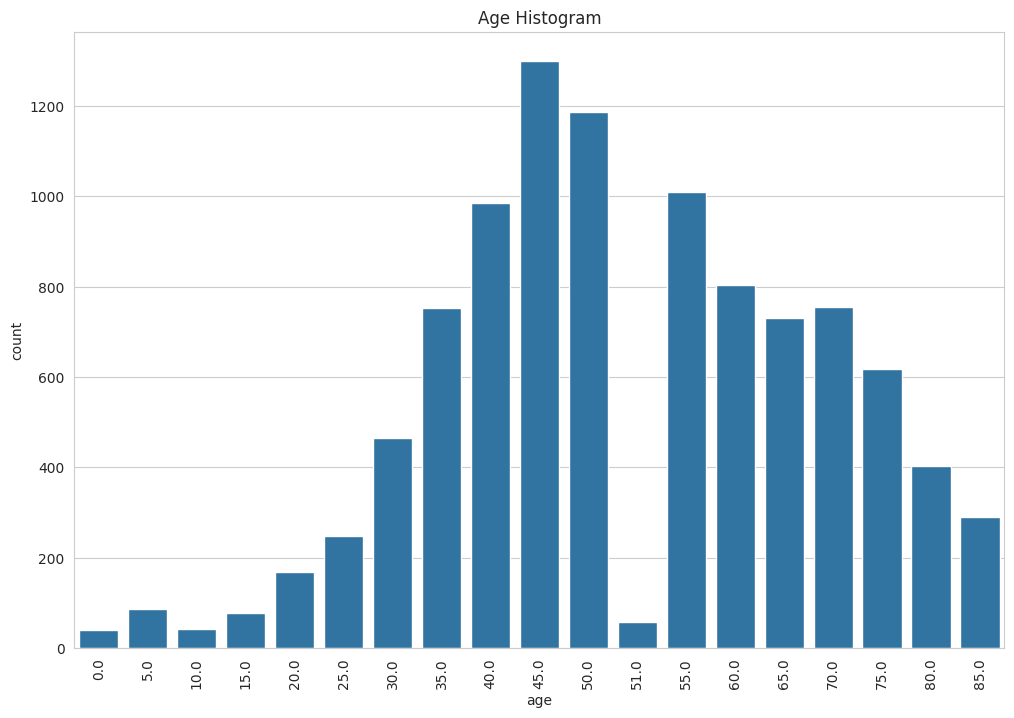

In [11]:
sns.set_style('whitegrid')
fig,axes = plt.subplots(figsize=(12,8))
ax = sns.countplot(x = 'age', data = df)
plt.title('Age Histogram')
plt.xticks(rotation=90)
plt.show()

Furthermore, we can observe the presence of `Age` 0, which could represent missing data or a recording error rather than the actual age of the patients. Therefore, by **removing `Age` equal to 0**, we are able to exclude invalid or inconsistent data from the analysis, thus improving the accuracy of our assessments regarding the distribution of ages of patients affected by skin cancer lesions.

In [12]:
df= df[df['age'] != 0]

### ***GRAPH REPRESENTING LOCALIZATION DISTRIBUTION***

The most common localizations for skin cancer are the *back* and the *lower extremity*, with over 2,000 cases each. Following these are the *trunk*, with around 1,400 cases, and the *upper extremities* and *abdomen*, each with approximately 1,000 cases.
The least common localizations for skin cancer are the *genitals* and the *acral* areas.

<ipython-input-13-2ec8e6ca6202>:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.countplot(x='localization', data=df, order=df['localization'].value_counts().index, palette='crest')


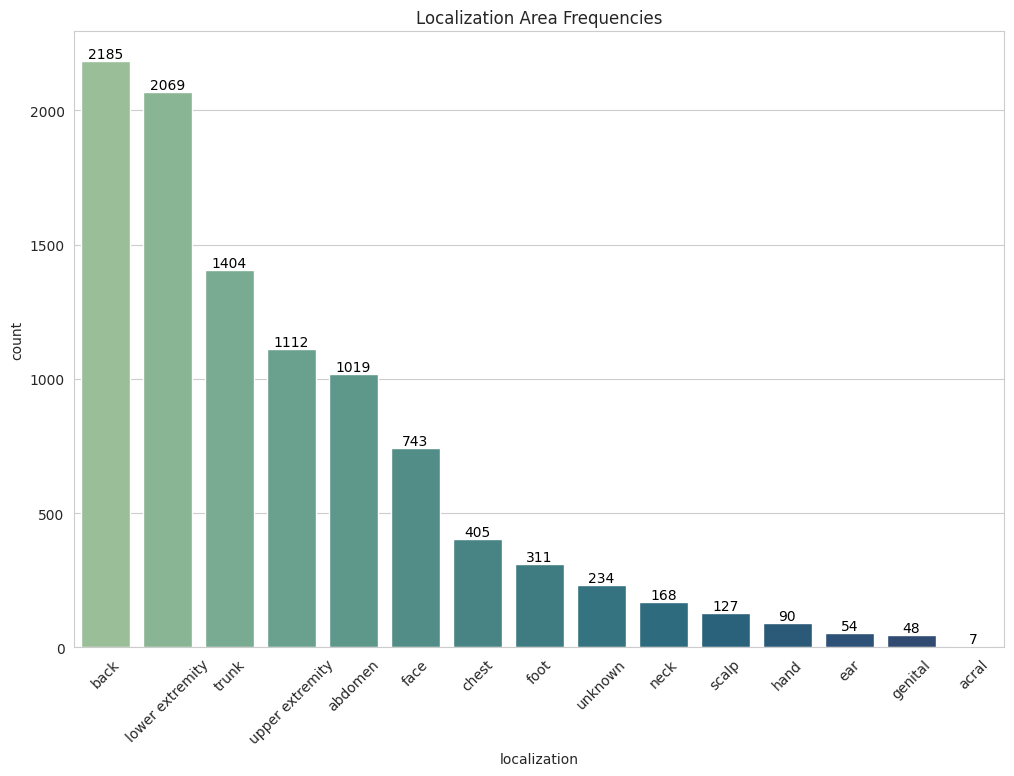

In [13]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.set_style('whitegrid')
fig, axis = plt.subplots(figsize=(12, 8))
ax = sns.countplot(x='localization', data=df, order=df['localization'].value_counts().index, palette='crest')
plt.title('Localization Area Frequencies')
plt.xticks(rotation=45)

# Add text annotations to each bar showing the exact count number
for p in ax.patches:
    ax.annotate(f'{int(p.get_height())}', (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', fontsize=10, color='black', xytext=(0, 5),
                textcoords='offset points')

plt.show()


We noticed from the graph the presence of a category labeled *unknown*. To enhance the analysis, we opted to remove the rows containing the `localization` *unknown* because they may represent missing data or unavailable information. By doing so, we eliminate uninformative data, enabling a more accurate analysis.

In [14]:
df= df[df['localization'] != 'unknown']

### ***GRAPH REPRESENTING SEX DISTRIBUTION***



We now examine the distribution of `sex` and observe that there are around 1,000 more *males* than *females*.

<ipython-input-15-a03a95641581>:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.countplot(x='sex', data=df, order=df['sex'].value_counts().index, palette='crest')


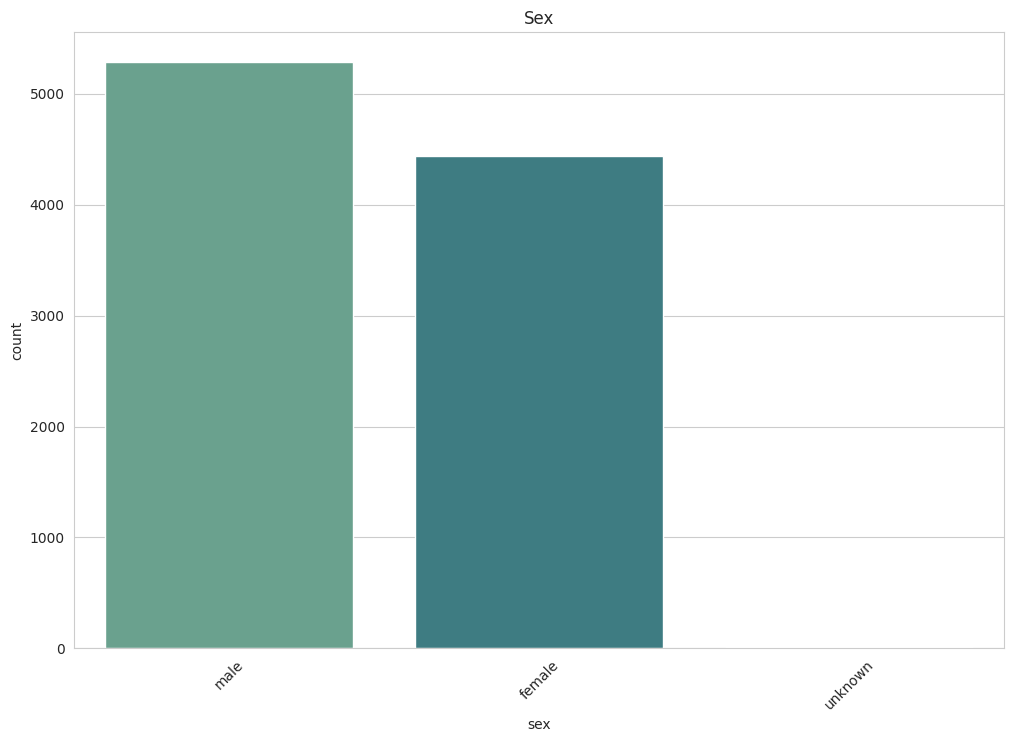

In [15]:
sns.set_style('whitegrid')
fig,axis = plt.subplots(figsize=(12,8))
ax = sns.countplot(x='sex', data=df, order=df['sex'].value_counts().index, palette='crest')
plt.title('Sex')
plt.xticks(rotation=45)
plt.show()

We notice the presence of a category labeled *unknown*, which we decide to remove to enhance the accuracy of our analysis.

In [16]:
df= df[df['sex'] != 'unknown']

### ***ANALYZING DIAGNOSIS CLASS IMBALANCE***

First, we define the variable `base_skin_dir`, which indicates the path of the main directory containing the images. Then, a dictionary called `lesion_type_dict` is created, which maps lesion diagnosis codes to their corresponding names. Using a dictionary comprehension, another dictionary called `imageid_path_dict` is created. This dictionary associates the image file names (without extension) with their respective paths to the .jpg files within the subdirectories of `base_skin_dir`.

Next, three new columns are added to the DataFrame:

* `path`: containing the complete path of each image, extracted from the `imageid_path_dict` using the value present in the `image_id` column.

* `cell_type`: containing the full name of the lesion diagnosis. This is achieved by mapping the values present in the `dx` column using the `lesion_type_dict`

* `cell_type_idx`: a categorical variable (from 0 to 6) for each lesion diagnosis class.

In [17]:
base_skin_dir = '/content/drive/MyDrive'

lesion_type_dict = {
    'nv': 'Melanocytic nevi',
    'mel': 'Melanoma',
    'bkl': 'Benign keratosis-like lesions ',
    'bcc': 'Basal cell carcinoma',
    'akiec': 'Actinic keratoses',
    'vasc': 'Vascular lesions',
    'df': 'Dermatofibroma'
}

# This creates a path pointing to all subdirectories (indicated by '*') within base_skin_dir, containing files with the .jpg extension.
# It utilizes a dictionary comprehension to iterate through all the paths of the .jpg files found and create a dictionary.
# For each path x, os.path.splitext(os.path.basename(x))[0] returns the file name without extension, which is used as the key of the dictionary.

imageid_path_dict = {os.path.splitext(os.path.basename(x))[0]: x
                     for x in glob(os.path.join(base_skin_dir, '*', '*.jpg'))}


df['path'] = df['image_id'].map(imageid_path_dict.get)

# cell_type column
df['cell_type'] = df['dx'].map(lesion_type_dict.get)
# cell_type_idx categorical column
df['cell_type_idx'] = pd.Categorical(df['cell_type']).codes
df.head()


lesion_id      image_id   dx dx_type   age   sex localization  \
0  HAM_0000118  ISIC_0027419  bkl   histo  80.0  male        scalp   
1  HAM_0000118  ISIC_0025030  bkl   histo  80.0  male        scalp   
2  HAM_0002730  ISIC_0026769  bkl   histo  80.0  male        scalp   
3  HAM_0002730  ISIC_0025661  bkl   histo  80.0  male        scalp   
4  HAM_0001466  ISIC_0031633  bkl   histo  75.0  male          ear   

                                                path  \
0  /content/drive/MyDrive/HAM10000_images_part_1/...   
1  /content/drive/MyDrive/HAM10000_images_part_1/...   
2  /content/drive/MyDrive/HAM10000_images_part_1/...   
3  /content/drive/MyDrive/HAM10000_images_part_1/...   
4  /content/drive/MyDrive/HAM10000_images_part_2/...   

                        cell_type  cell_type_idx  
0  Benign keratosis-like lesions               2  
1  Benign keratosis-like lesions               2  
2  Benign keratosis-like lesions               2  
3  Benign keratosis-like lesions               2  
4  Benign keratosis-like lesions               2

Now, we generate a bar plot using `Plotly` to visually represent the distribution of observations across different diagnostic categories (`dx`) of skin cancer lesions. This allows us to visualize the potential imbalance in class distribution.

In [18]:
counts = df['dx'].value_counts()

colors = ['maroon', 'darkred', 'brown', 'indianred', 'lightcoral', 'rosybrown', 'darksalmon']

fig = go.Figure(
    data=[go.Bar(x=counts.index, y=counts.values, marker=dict(color=colors))],
    layout_title_text="Distribution of observations across diagnostic categories"
)

fig.update_layout(xaxis_title="Class", yaxis_title="Count")

fig.update_traces(hovertemplate='Class: %{text}<br>Count: %{y}',
                  text=[lesion_type_dict[label] for label in counts.index])

fig.update_traces(textposition='none')

fig.show()

Our dataset is imbalanced, prompting us to aim for 230 observations per class to achieve balance. This decision is based on the fact that the smallest class (`df`) contains 115 observations, and we aim to augment each original image in this class a maximum of one time. Therefore, combining the original 115 images with 115 augmented images results in a total of 230 observations.
However, this approach can lead to training issues, potentially reducing model accuracy and increasing the risk of overfitting.

Now, to address the imbalance in class distribution, we perform downsampling by randomly selecting 230 observations for each class with more than 230 observations.

In [19]:
np.random.seed(42)

for label, count in counts.items():
    if count > 230:
        # selecting indexes for class
        indices_to_keep = df[df['dx'] == label].index

        # selecting randomly the indexes from the total
        random_indices_to_keep = np.random.choice(indices_to_keep, size=230, replace=False)

        # removing additional observations
        remove_indices = set(indices_to_keep) - set(random_indices_to_keep)
        df = df.drop(remove_indices)

print("Number of observations for each class:")
print(df['dx'].value_counts())
print("Number of total observations:")
print(df.shape[0])

Number of observations for each class:
bkl      230
mel      230
bcc      230
akiec    230
nv       230
vasc     138
df       115
Name: dx, dtype: int64
Number of total observations:
1403


As we can observe, the categories "*vasc*" and "*df*" have significantly fewer observations compared to the threshold of 230. To achieve a more balanced dataset, we will apply data augmentation techniques to these two categories.

### ***Data Augmentation on 'vasc' and 'df' Classes***

Data augmentation is a widely used technique in machine learning and computer vision, particularly in scenarios where the available dataset is limited or imbalanced. However, it's essential to strike a balance between augmentation and avoiding redundancy in the data. Therefore, we opted for a conservative approach, limiting augmentation to one per image.

By applying data augmentation to the "*vasc*" and "*df*" categories, we aim to increase the diversity and quantity of data for these classes without overdoing it. This approach helps to improve the generalization and robustness of machine learning models by exposing them to a broader range of variations and scenarios within these underrepresented classes.

In [20]:
#It read image files specified in the 'path' column using the PIL library and convert them into NumPy arrays.
df['image'] = df['path'].apply(lambda x: np.array(Image.open(x)))

In [21]:
df_class = df[df['dx'] == 'df']
vasc_Randclass = df[df['dx'] == 'vasc'].sample(n=92, random_state=42)

balanced_df = pd.concat([df_class, vasc_Randclass])


We utilize data augmentation through the `ImageDataGenerator` provided by the `Keras` library. Our augmentation strategy includes rotating images by up to 30 degrees, applying horizontal and vertical flips, and randomly adjusting the brightness of the image. The '`Fill mode`' parameter determines how newly created pixels resulting from rotation or shifting are filled in; we set it to '*nearest*', which means the value of the nearest pixel will be used.

In [22]:
datagen = ImageDataGenerator(
        rotation_range = 30,
        fill_mode = 'nearest',
        horizontal_flip = True,
        vertical_flip = True,
        brightness_range = [0.4,1.5]
        )

In [23]:
nuovo_dataset = pd.DataFrame(columns=df.columns)

# Data Augmented images path
aug_skin_dir = '/content/drive/MyDrive/DataAug'

# Create a dictionary that maps image IDs to their corresponding file paths by iterating over the files with the .jpg extension within the specified directory structure.
imageid_path_dict = {os.path.splitext(os.path.basename(x))[0]: x
                     for x in glob(os.path.join(aug_skin_dir, '*', '*.jpg'))}

for index, row in balanced_df.iterrows():
    img_aug = datagen.flow(np.expand_dims(row['image'], axis=0), batch_size=32) #during the data augmentation process, the images are processed in batches containing 32 images each

    for augmented_img in img_aug:
        nuova_riga = row.copy()
        image_id = str(uuid.uuid4())[:8]   #A unique image ID is generated using the uuid library

        # the original image ID is prefixed with 'T'
        new_image_id = 'T' + row['image_id']

        new_image_name = f"{new_image_id}_transformed_{image_id}.jpg"
        output_path = os.path.join(aug_skin_dir, new_image_name)

        Image.fromarray(augmented_img[0].astype('uint8')).save(output_path)  #The augmented image is saved with a new filename

        nuova_riga['path'] = output_path
        nuova_riga['image_id'] = new_image_id
        nuova_riga['image'] = np.asarray(Image.open(output_path).resize((224, 224)))
        nuovo_dataset = nuovo_dataset.append(nuova_riga, ignore_index=True)

        break

<ipython-input-23-65e0f69bd035>:28: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



In [24]:
nuovo_dataset.head()  #dataset of only the Augmented images

lesion_id       image_id  dx dx_type   age     sex     localization  \
0  HAM_0005276  TISIC_0027008  df   histo  75.0    male             back   
1  HAM_0005276  TISIC_0028790  df   histo  75.0    male             back   
2  HAM_0004103  TISIC_0028880  df   histo  55.0    male  lower extremity   
3  HAM_0004103  TISIC_0031309  df   histo  55.0    male  lower extremity   
4  HAM_0001164  TISIC_0030021  df   histo  50.0  female  upper extremity   

                                                path       cell_type  \
0  /content/drive/MyDrive/DataAug/TISIC_0027008_t...  Dermatofibroma   
1  /content/drive/MyDrive/DataAug/TISIC_0028790_t...  Dermatofibroma   
2  /content/drive/MyDrive/DataAug/TISIC_0028880_t...  Dermatofibroma   
3  /content/drive/MyDrive/DataAug/TISIC_0031309_t...  Dermatofibroma   
4  /content/drive/MyDrive/DataAug/TISIC_0030021_t...  Dermatofibroma   

  cell_type_idx                                              image  
0             3  [[[154, 113, 107], [157, 116, 110], [157, 117,...  
1             3  [[[209, 163, 165], [206, 160, 162], [203, 157,...  
2             3  [[[163, 140, 166], [163, 140, 166], [159, 136,...  
3             3  [[[14, 8, 20], [12, 6, 18], [13, 7, 19], [14, ...  
4             3  [[[198, 151, 161], [199, 152, 162], [200, 153,...

In [25]:
df = pd.concat([df, nuovo_dataset], ignore_index=True)  #final dataset = Original + Augmented img

In [26]:
print(df['dx'].value_counts())

bkl      230
df       230
mel      230
vasc     230
bcc      230
nv       230
akiec    230
Name: dx, dtype: int64


In [27]:
Original_image_path = df.loc[df['image_id'] == 'ISIC_0027008', 'path'].values[0]

Augmented_image_path = df.loc[df['image_id'] == 'TISIC_0027008', 'path'].values[0]

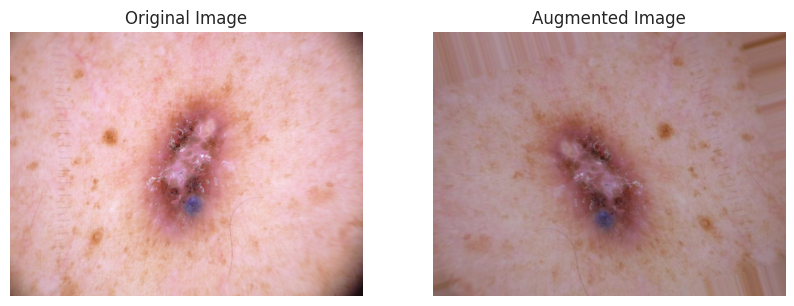

In [28]:
import matplotlib.pyplot as plt
import cv2
original_image = cv2.imread(Original_image_path)
augmented_image = cv2.imread(Augmented_image_path)

original_image = cv2.cvtColor(original_image, cv2.COLOR_BGR2RGB)
augmented_image = cv2.cvtColor(augmented_image, cv2.COLOR_BGR2RGB)

# Calcola le dimensioni delle immagini
height, width, _ = original_image.shape

# Plot delle immagini originali e aumentate con le stesse dimensioni
plt.figure(figsize=(10, 5))

# Plot dell'immagine originale
plt.subplot(1, 2, 1)
plt.imshow(original_image, extent=[0, width, height, 0])
plt.title('Original Image')
plt.axis('off')

# Plot dell'immagine aumentata
plt.subplot(1, 2, 2)
plt.imshow(augmented_image, extent=[0, width, height, 0])
plt.title('Augmented Image')
plt.axis('off')

plt.show()

Final dataset:

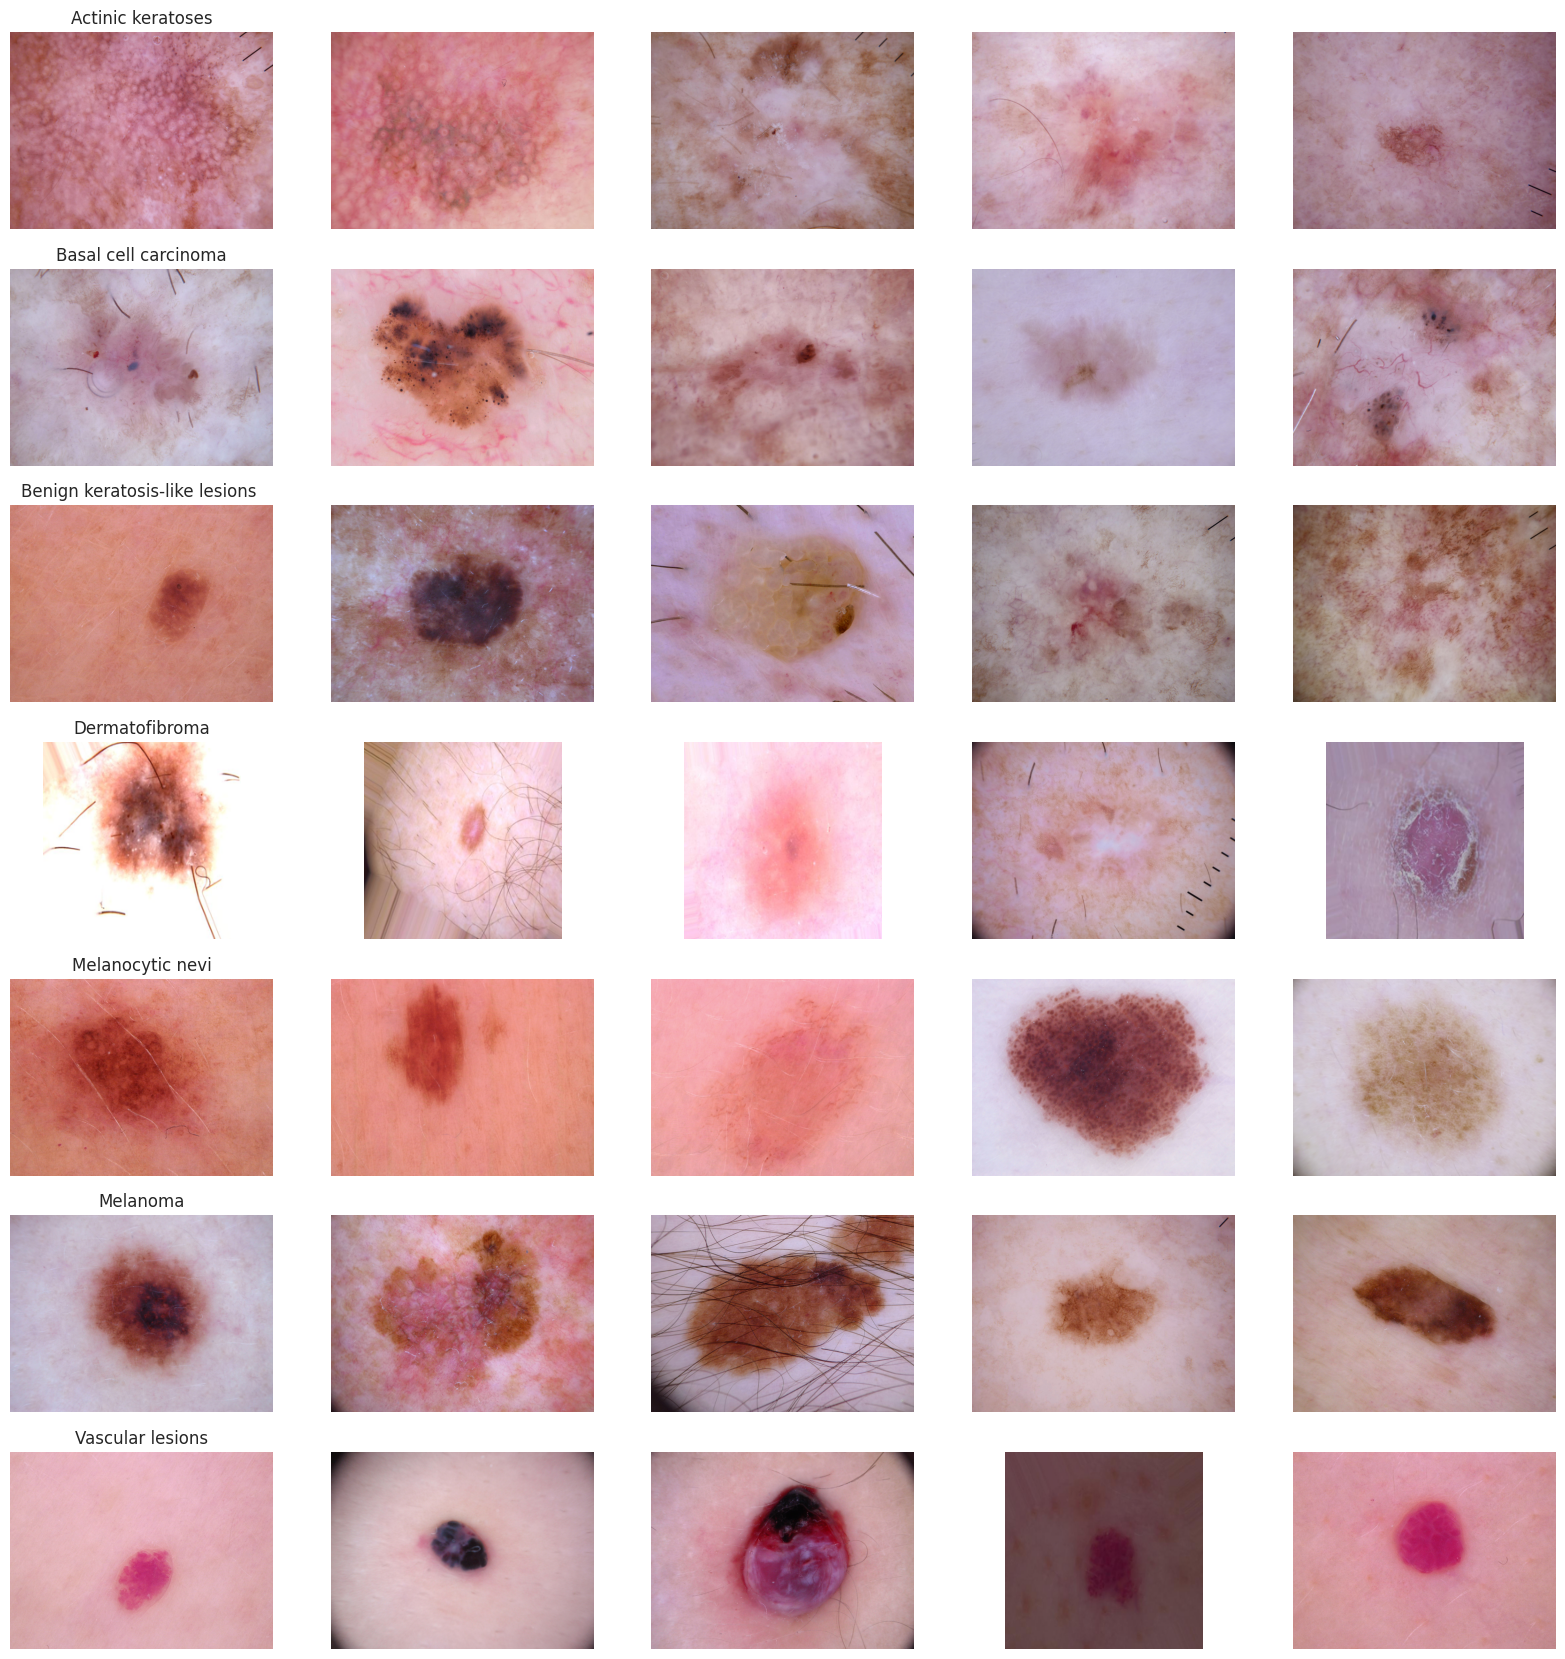

In [29]:
n_samples = 5
fig, m_axs = plt.subplots(7, n_samples, figsize = (4*n_samples, 3*7))
for n_axs, (type_name, type_rows) in zip(m_axs,
                                         df.sort_values(['cell_type']).groupby('cell_type')):
    n_axs[0].set_title(type_name)
    for c_ax, (_, c_row) in zip(n_axs, type_rows.sample(n_samples, random_state=2018).iterrows()):
        c_ax.imshow(c_row['image'])
        c_ax.axis('off')
fig.savefig('category_samples.png', dpi=300)

## ***ALEXNET: Deep Convolutional Neural Network***

* **Deeper Architecture**: AlexNet is an 8-layer Convolutional Neural Network (CNN),
which is deeper than LeNet. This increased depth allows AlexNet to learn more complex hierarchical features from the input data.

* **Use of ReLU Activation**: AlexNet employs the Rectified Linear Unit (ReLU) activation function, which helps mitigate the vanishing gradient problem and accelerates the convergence of the training process.

* **Adoption of MaxPooling**: AlexNet uses max-pooling layers to downsample the spatial dimensions of the feature maps, aiding in translation invariance and reducing the computational burden.

* **Winner of ImageNet Challenge 2012**: One of the most significant achievements of AlexNet was winning the ImageNet Large Scale Visual Recognition Challenge in 2012. This competition played a crucial role in showcasing the capabilities of deep learning models on large-scale image classification tasks.

### ***TRAIN, VALIDATION, TEST SPLITTING***

The proportions used for splitting into train, test, and validation sets are as follows:
- Train: 80%
- Validation: 10%
- Test: 10%

We just use `sklearn.model_selection.train_test_split` twice. First to split to train, test and then split train again into validation and train:

In [83]:
X_train, X_test = train_test_split(df, test_size=0.1, random_state=42)

X_train, X_val = train_test_split(X_train, test_size=0.1111, random_state=42)

In [31]:
X_train.head()

lesion_id       image_id     dx    dx_type   age   sex  \
449   HAM_0005970   ISIC_0032806    mel      histo  65.0  male   
1289  HAM_0002441   ISIC_0031381  akiec      histo  80.0  male   
226   HAM_0007219   ISIC_0029227    bkl  consensus  70.0  male   
1563  HAM_0003862  TISIC_0032775   vasc      histo  45.0  male   
160   HAM_0003392   ISIC_0030240    bkl      histo  70.0  male   

         localization                                               path  \
449             chest  /content/drive/MyDrive/HAM10000_images_part_2/...   
1289            scalp  /content/drive/MyDrive/HAM10000_images_part_2/...   
226              hand  /content/drive/MyDrive/HAM10000_images_part_1/...   
1563  upper extremity  /content/drive/MyDrive/DataAug/TISIC_0032775_t...   
160             scalp  /content/drive/MyDrive/HAM10000_images_part_2/...   

                           cell_type cell_type_idx  \
449                         Melanoma             5   
1289               Actinic keratoses             0   
226   Benign keratosis-like lesions              2   
1563                Vascular lesions             6   
160   Benign keratosis-like lesions              2   

                                                  image  
449   [[[129, 93, 93], [132, 96, 98], [133, 98, 104]...  
1289  [[[190, 93, 126], [191, 94, 129], [192, 95, 13...  
226   [[[201, 102, 120], [209, 103, 126], [209, 103,...  
1563  [[[145, 126, 132], [145, 126, 132], [145, 126,...  
160   [[[134, 114, 113], [134, 114, 115], [133, 113,...

In [32]:
# check subsets length
print('Check subsets length:')
print(' train:', len(X_train),'\n','validation:', len(X_val), '\n','test:', len(X_test))
print('Sum of lengths:', len(X_train)+len(X_val)+len(X_test))

Check subsets length:
 train: 1288 
 validation: 161 
 test: 161
Sum of lengths: 1610


Thanks to data augmentation, we achieved a balanced distribution of classes in the training set.

In [33]:
X_train['dx'].value_counts()

nv       192
akiec    190
bkl      186
vasc     183
mel      180
df       180
bcc      177
Name: dx, dtype: int64

### ***IMPORT DATA AS `ImageFolder`***


We arrange the images from the Train, Validation, and Test sets into subfolders corresponding to their class labels. Then, employing `transforms.Compose()`, we define transformations such as resizing to 224x224 pixels and conversion to tensors. Subsequently, we create datasets using `ImageFolder` from the `torchvision.datasets` module, seamlessly integrating the specified image transformations.

### ***TRAIN FOLDER WITH SUBCATEGORIES***

In [84]:
train_path = '/content/drive/MyDrive/Colab Notebooks/Train'

# Make sure the subfolder exists, otherwise create it
if not os.path.exists(train_path):
    os.makedirs(train_path)

# Organizing images in subcategories for each 'cell_type' class
for index, row in X_train.iterrows():
    image_path = row['path']  # Get the path of the image
    label = row['cell_type']  # Get the label of the image

    # Create the subfolder path for the class
    class_folder_path = os.path.join(train_path, label)
    if not os.path.exists(class_folder_path):
        os.makedirs(class_folder_path)

    # Copy the image to the corresponding subfolder
    filename = os.path.basename(image_path)  # Get the filename of the image
    new_image_path = os.path.join(class_folder_path, filename)  # Create the new path for the image
    shutil.copy(image_path, new_image_path) # Copy the image

# Transform images
image_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor()
])

# Create dataset with ImageFolder
train_dataset = ImageFolder(train_path, transform=image_transforms)



### ***TEST FOLDER WITH SUBCATEGORIES***

In [35]:
test_path = '/content/drive/MyDrive/Colab Notebooks/Test'

if not os.path.exists(test_path):
    os.makedirs(test_path)

for index, row in X_test.iterrows():
    image_path = row['path']
    label = row['cell_type']

    class_folder_path = os.path.join(test_path, label)

    if not os.path.exists(class_folder_path):
        os.makedirs(class_folder_path)

    filename = os.path.basename(image_path)  # Get the filename of the image
    new_image_path = os.path.join(class_folder_path, filename)  # Create the new path for the image
    shutil.copy(image_path, new_image_path)  # Copy the image

image_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor()
])

test_dataset = ImageFolder(test_path, transform=image_transforms)


### ***VALIDATION FOLDER WITH SUBCATEGORIES***

In [36]:
val_path = '/content/drive/MyDrive/Colab Notebooks/Validation'

if not os.path.exists(val_path):
    os.makedirs(val_path)

for index, row in X_val.iterrows():
    image_path = row['path']
    label = row['cell_type']

    class_folder_path = os.path.join(val_path, label)

    if not os.path.exists(class_folder_path):
        os.makedirs(class_folder_path)

    filename = os.path.basename(image_path)
    new_image_path = os.path.join(class_folder_path, filename)
    shutil.copy(image_path, new_image_path)

image_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor()
])

val_dataset = ImageFolder(val_path, transform=image_transforms)


### ***ALEXNET IMPLEMENTATION***

In [59]:
batch_size = 16
train_dataloader = data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True) # data is randomly shuffled before being divided into batches.
valid_dataloader = data.DataLoader(val_dataset, batch_size=batch_size, shuffle=False)  # data are not shuffled
test_dataloader = data.DataLoader(test_dataset, batch_size=1, shuffle=False)

In [60]:
import torch
import torch.nn as nn

class AlexNet(nn.Module):
    def __init__(self, num_classes):
        super(AlexNet, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 96, kernel_size=11, stride=4, padding=2),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(96),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.Conv2d(96, 256, kernel_size=5, padding=2),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(256),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.Conv2d(256, 384, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(384, 384, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(384, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
        )
        self.avgpool = nn.AdaptiveAvgPool2d((6, 6))
        self.classifier = nn.Sequential(
            nn.Linear(256 * 6 * 6, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(),
            nn.Linear(4096, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(),
            nn.Linear(4096, num_classes),
        )

    def forward(self, x):
        x = self.features(x)
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x

num_classes = 7
alexnet = AlexNet(num_classes)

print(alexnet)

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 96, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(96, 256, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (5): ReLU(inplace=True)
    (6): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (8): Conv2d(256, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(384, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  

In [61]:
# Create an instance of the AlexNet model
num_classes = 7
model = AlexNet(num_classes=num_classes)


### ***TRAINING THE MODEL***

Next, we create the `train` function, which will serve to assess our models' performance by monitoring metrics like training and validation accuracy, as well as training loss.

In [62]:
def evaluate_accuracy_gpu(net, data_iter, device=None):
    if isinstance(net, torch.nn.Module):
        net.eval()
        if not device:
            device = next(iter(net.parameters())).device
    metric = d2l.Accumulator(2)
    for X, y in data_iter:
        if isinstance(X, list):
            X = [x.to(device) for x in X]
        else:
            X = X.to(device)
        y = y.to(device)
        metric.add(d2l.accuracy(net(X), y), y.numel())
    return metric[0] / metric[1]

loss 0.771, train acc 0.718, valid acc 0.584, test acc 0.578
324.8 examples/sec on cuda:0


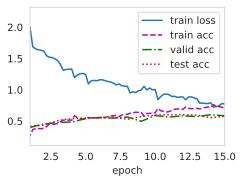

In [65]:
from d2l import torch as d2l
def train(net, train_iter, test_iter, valid_iter, num_epochs, lr,
              device=d2l.try_gpu()):
    def init_weights(m):
        if type(m) == nn.Linear or type(m) == nn.Conv2d:
            nn.init.xavier_uniform_(m.weight)

    # Apply Xavier initialization to the model weights
    net.apply(init_weights)
    print('training on', device)

    # Move the model to the specified device (GPU)
    net.to(device)

    # Use the Adam optimizer with the specified learning rate
    optimizer = torch.optim.Adam(net.parameters(), lr=lr)

    # Define the CrossEntropyLoss as the loss function
    loss = nn.CrossEntropyLoss()

    # Initialize an animator for visualization
    animator = d2l.Animator(xlabel='epoch', xlim=[1, num_epochs],
                        legend=['train loss', 'train acc', 'valid acc', 'test acc'])

    # Initialize a timer and get the number of batches in the training set
    timer, num_batches = d2l.Timer(), len(train_iter)

    for epoch in range(num_epochs):
        # Sum of training loss, sum of training accuracy, number of examples
        metric = d2l.Accumulator(3)
        net.train()

        for i, (X, y) in enumerate(train_iter):
            timer.start()

            # Zero the gradients, move data to GPU, and forward pass
            optimizer.zero_grad()
            X, y = X.to(device), y.to(device)
            y_hat = net(X)

            # Calculate loss, perform backward pass, and update weights
            l = loss(y_hat, y)
            l.backward()
            optimizer.step()

            # Accumulate metrics
            with torch.no_grad():
                metric.add(l * X.shape[0], d2l.accuracy(y_hat, y), X.shape[0])
            timer.stop()

            # Calculate and display training loss and accuracy
            train_l = metric[0] / metric[2]
            train_acc = metric[1] / metric[2]
            if (i + 1) % (num_batches // 5) == 0 or i == num_batches - 1:
                animator.add(epoch + (i + 1) / num_batches,
                             (train_l, train_acc, None, None))

        # Evaluate the model on the validation set
        net.eval()
        valid_acc = evaluate_accuracy_gpu(net, valid_iter, device=device)
        animator.add(epoch + 1, (None, None, valid_acc, None))

        # Evaluate the model on the test set
        test_acc = evaluate_accuracy_gpu(net, test_iter, device=device)
        animator.add(epoch + 1, (None, None, None, test_acc))

    # Print final results
    print(f'loss {train_l:.3f}, train acc {train_acc:.3f}, '
          f'valid acc {valid_acc:.3f}, test acc {test_acc:.3f}')
    print(f'{metric[2] * num_epochs / timer.sum():.1f} examples/sec '
          f'on {str(device)}')

# Train the model with the Adam optimizer
train(model, train_dataloader, test_dataloader, valid_dataloader, num_epochs=15, lr=0.00001)


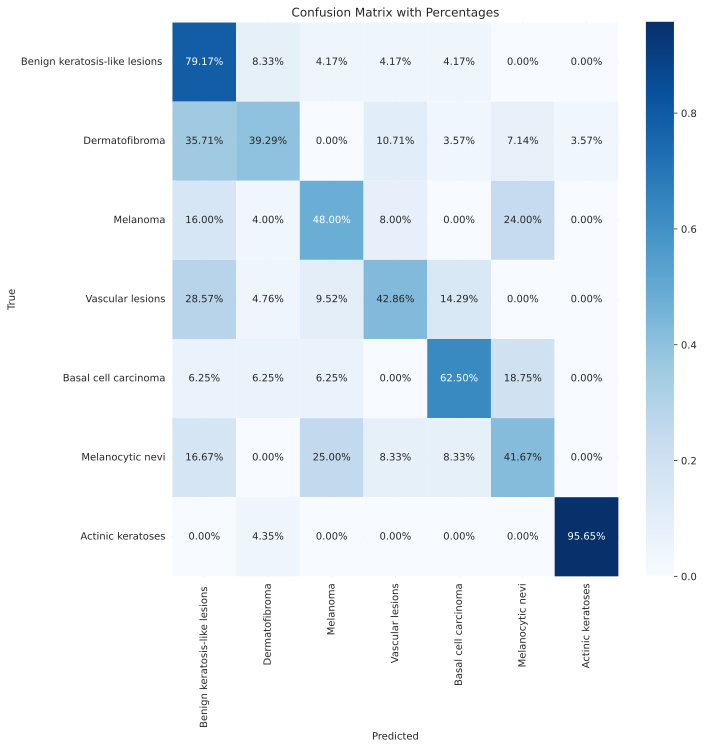

In [66]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Function to plot confusion matrix with percentages
def plot_confusion_matrix_with_percentages(y_true, y_pred, class_names):
    cm = confusion_matrix(y_true, y_pred)
    cm_percentages = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    plt.figure(figsize=(10, 10))
    sns.heatmap(cm_percentages, annot=True, fmt=".2%", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.title("Confusion Matrix with Percentages")
    plt.show()

# Make predictions on the test set
all_predictions = []
all_labels = []

model.eval()

for img, labels in test_dataloader:
    with torch.no_grad():
        img, labels = img.to(device), labels.to(device)
        outputs = model(img)
        _, predicted = torch.max(outputs, 1)

    all_predictions.extend(predicted.cpu().numpy())
    all_labels.extend(labels.cpu().numpy())

# Get class names from the dataset
class_names = df['cell_type'].unique()

# Plot the confusion matrix with percentages
plot_confusion_matrix_with_percentages(all_labels, all_predictions, class_names)

The performance of the AlexNet model in classifying various skin lesions appears to be promising, particularly evident from the high values observed along the diagonal of the confusion matrix. Notably, the model demonstrates strong accuracy in distinguishing between benign keratosis-like lesions, basal cell carcinoma, and actinic keratoses, with accuracies ranging from 62.5% to 95.65%.

## ***ALEXNET WITH LOCALIZATION***

Despite the imbalance observed in the '`localization`' variable during data visualization, we proceeded to implement an MLP layer parallel to the existing CNN model. Our objective is to leverage both models to enhance the prediction accuracy of diagnostic classes.

In [68]:
X_train = X_train[['path','localization','cell_type_idx']]
X_test = X_test[['path','localization','cell_type_idx']]
X_val = X_val[['path','localization','cell_type_idx']]

In [45]:
X_train

path     localization  \
449   /content/drive/MyDrive/HAM10000_images_part_2/...            chest   
1289  /content/drive/MyDrive/HAM10000_images_part_2/...            scalp   
226   /content/drive/MyDrive/HAM10000_images_part_1/...             hand   
1563  /content/drive/MyDrive/DataAug/TISIC_0032775_t...  upper extremity   
160   /content/drive/MyDrive/HAM10000_images_part_2/...            scalp   
...                                                 ...              ...   
685   /content/drive/MyDrive/HAM10000_images_part_1/...             face   
959   /content/drive/MyDrive/HAM10000_images_part_2/...  upper extremity   
1264  /content/drive/MyDrive/HAM10000_images_part_1/...             back   
1237  /content/drive/MyDrive/HAM10000_images_part_2/...             face   
658   /content/drive/MyDrive/HAM10000_images_part_2/...          abdomen   

     cell_type_idx  
449              5  
1289             0  
226              2  
1563             6  
160              2  
...            ...  
685              6  
959              4  
1264             0  
1237             0  
658              6  

[1288 rows x 3 columns]

In [69]:
from sklearn.preprocessing import LabelBinarizer
localizationBinarizer = LabelBinarizer()
localized_encodedtrain = localizationBinarizer.fit_transform(X_train["localization"])

#trasformation
localized_encodedtest = localizationBinarizer.transform(X_test["localization"])
localized_encodedval = localizationBinarizer.transform(X_val["localization"])

#Replacement of the 'localization' column with the transformed array
X_train['localization'] = list(localized_encodedtrain)
X_test['localization'] = list(localized_encodedtest)
X_val['localization'] = list(localized_encodedval)


In [70]:
#Convert the pandas DataFrame into a list of tuples
X_train = [(row['path'], row['localization'], row['cell_type_idx']) for index, row in X_train.iterrows()]
X_test = [(row['path'], row['localization'], row['cell_type_idx']) for index, row in X_test.iterrows()]
X_val = [(row['path'], row['localization'], row['cell_type_idx']) for index, row in X_val.iterrows()]


In [71]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize images to a fixed size
    transforms.ToTensor(),          # Convert images to PyTorch tensors
])

In [72]:
transformed_X_train = [(transform(Image.open(path)), localization, cell_type_idx) for path, localization, cell_type_idx in X_train]
transformed_X_test = [(transform(Image.open(path)), localization, cell_type_idx) for path, localization, cell_type_idx in X_test]
transformed_X_val = [(transform(Image.open(path)), localization, cell_type_idx) for path, localization, cell_type_idx in X_val]


In [73]:
batch_size = 16  # Adjust batch size as needed
train_dataloader = torch.utils.data.DataLoader(transformed_X_train, batch_size=batch_size, shuffle=True)
test_dataloader = torch.utils.data.DataLoader(transformed_X_test, batch_size=batch_size, shuffle=False)
valid_dataloader = torch.utils.data.DataLoader(transformed_X_val, batch_size=batch_size, shuffle=False)

In [74]:
class AlexNetWithLocalization(nn.Module):
    def __init__(self, num_classes):
        super(AlexNetWithLocalization, self).__init__()
        # AlexNet layers for image processing
        self.features = nn.Sequential(
            nn.Conv2d(3, 96, kernel_size=11, stride=4, padding=2),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(96),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.Conv2d(96, 256, kernel_size=5, padding=2),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(256),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.Conv2d(256, 384, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(384, 384, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(384, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
        )
        self.avgpool = nn.AdaptiveAvgPool2d((6, 6))
        self.classifier = nn.Sequential(
            nn.Linear(256 * 6 * 6, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(),
            nn.Linear(4096, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(),
            nn.Linear(4096, num_classes),
        )
        # Localization layers
        self.localization_fc = nn.Sequential(
            nn.Linear(14, 64),  # Assuming the localization input has 14 features
            nn.ReLU(inplace=True),
            nn.Dropout(),
            nn.Linear(64, num_classes),
            nn.ReLU(inplace=True),

        )


    def forward(self, x_image, x_localization):
        # Process the image through AlexNet layers
        x_image = self.features(x_image)
        x_image = self.avgpool(x_image)
        x_image = torch.flatten(x_image, 1)
        x_image = self.classifier(x_image)

        # Process the localization through localization layers
        x_localization = self.localization_fc(x_localization.float())

        # Concatenate image and localization features
        x = torch.cat((x_image, x_localization), dim=1)

        return x



In [75]:
def evaluate_accuracy_gpu(net, data_iter, device=None):
    if isinstance(net, torch.nn.Module):
        net.eval()
        if not device:
            device = next(iter(net.parameters())).device
    metric = d2l.Accumulator(2)
    for batch in data_iter:
        img, localization, labels = batch
        img, localization, labels = img.to(device), localization.to(device), labels.to(device)
        y_hat = net(img, localization)
        metric.add(d2l.accuracy(y_hat, labels), labels.numel())
    return metric[0] / metric[1]


In [76]:
# Training function
def train(net, train_iter, test_iter, valid_iter, num_epochs, lr, device=d2l.try_gpu()):
    # Apply Xavier initialization to the model weights
    def init_weights(m):
        if type(m) == nn.Linear or type(m) == nn.Conv2d:
            nn.init.xavier_uniform_(m.weight)

    # Initialize the model and move it to the specified device (GPU)
    net.apply(init_weights)
    print('Training on', device)
    net.to(device)

    # Use the Adam optimizer with the specified learning rate
    optimizer = optim.Adam(net.parameters(), lr=lr)

    # Define the loss function
    loss = nn.CrossEntropyLoss()

    # Initialize an animator for visualization
    animator = d2l.Animator(xlabel='epoch', xlim=[1, num_epochs],
                            legend=['train loss', 'train acc', 'valid acc', 'test acc'])

    # Training loop
    for epoch in range(num_epochs):
        net.train()
        metric = d2l.Accumulator(3)

        for batch in train_iter:
            optimizer.zero_grad()
            img, localization, labels = batch
            img, localization, labels = img.to(device), localization.to(device), labels.to(device)
            y_hat = net(img, localization)
            l = loss(y_hat, labels)
            l.backward()
            optimizer.step()
            with torch.no_grad():
                metric.add(l * img.shape[0], d2l.accuracy(y_hat, labels), img.shape[0])

        # Calculate training loss and accuracy
        train_loss = metric[0] / metric[2]
        train_acc = metric[1] / metric[2]

        # Evaluate the model on the validation set
        valid_acc = evaluate_accuracy_gpu(net, valid_iter, device)

        # Evaluate the model on the test set
        test_acc = evaluate_accuracy_gpu(net, test_iter, device)

        # Update the animator
        animator.add(epoch + 1, (train_loss, train_acc, valid_acc, test_acc))

    # Print final results
    print(f'Loss {train_loss:.3f}, Train Acc {train_acc:.3f}, '
          f'Valid Acc {valid_acc:.3f}, Test Acc {test_acc:.3f}')


Loss 0.610, Train Acc 0.772, Valid Acc 0.634, Test Acc 0.565


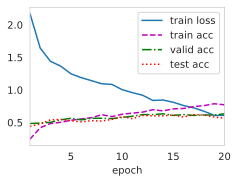

In [81]:
# Define the model, optimizer, and loss function
model = AlexNetWithLocalization(num_classes=7)
num_epochs = 20

# Train the model
train(model, train_dataloader, valid_dataloader, test_dataloader, num_epochs, lr=0.00001)


The blue line depicts the training loss, gradually decreasing after each epoch. However, the training loss keeps decreasing but validation and test increas roughly after the 10th epoch, which suggest a bit of overfitting.

Overfitting occurs when a model learns the training data too well, capturing noise and fluctuations that may not generalize well to the new and unseen data.

Confusion Matrix:

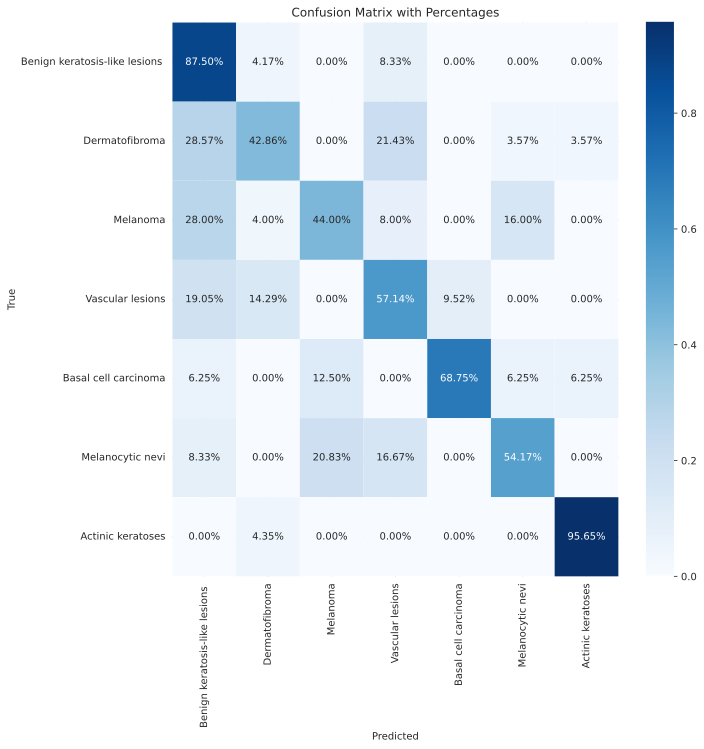

In [82]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Function to plot confusion matrix with percentages
def plot_confusion_matrix_with_percentages(y_true, y_pred, class_names):
    cm = confusion_matrix(y_true, y_pred)
    cm_percentages = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    plt.figure(figsize=(10, 10))
    sns.heatmap(cm_percentages, annot=True, fmt=".2%", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.title("Confusion Matrix with Percentages")
    plt.show()

# Make predictions on the test set
all_predictions = []
all_labels = []

model.eval()

for img, localization, labels in test_dataloader:
  img = img.to(device)
  localization = localization.to(device)
  with torch.no_grad():
    outputs = model(img, localization)
    _, predicted = torch.max(outputs, 1)

    all_predictions.extend(predicted.cpu().numpy())
    all_labels.extend(labels.cpu().numpy())

# Get class names from the dataset
class_names = df['cell_type'].unique()

# Plot the confusion matrix with percentages
plot_confusion_matrix_with_percentages(all_labels, all_predictions, class_names)

It seems that the model AlexNet, including localization, performs better overall. Notably, accuracies along the main diagonal are higher compared to those predicted by the initial AlexNet model. Additionally, apart from the prediction for melanoma, which has decreased by 4%, the accuracies for other diagnosis classes have notably improved.